In [120]:
# https://www.kaggle.com/code/ozlemilgun/market-basket-analysis-with-apriori-algorithm
# https://www.facebook.com/tautologyai/videos/303900072700235

In [121]:
import warnings
warnings.simplefilter("ignore")

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data

In [123]:
df = pd.read_excel("online_retail_II.xlsx")

In [124]:
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
303987,519015,22624,IVORY KITCHEN SCALES,1,2010-08-13 09:13:00,16.98,NaN,United Kingdom
32131,491981,85047,WHITE BEADED GARLAND STRING 20LIGHT,6,2009-12-15 09:34:00,6.35,13468.0,United Kingdom
348587,523313,22946,WOODEN ADVENT CALENDAR CREAM,4,2010-09-21 13:21:00,16.95,14936.0,Channel Islands
305472,519198,22469,HEART OF WICKER SMALL,3,2010-08-15 10:28:00,1.65,16104.0,United Kingdom
6852,490003,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2009-12-03 11:51:00,0.55,16159.0,United Kingdom


In [125]:
df.shape

(525461, 8)

# 2. Check data quality

In [126]:
# columns name

In [127]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [128]:
# select only useful columns

In [129]:
df = df[['Invoice','StockCode','Description']]

In [130]:
# data type

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Invoice      525461 non-null  object
 1   StockCode    525461 non-null  object
 2   Description  522533 non-null  object
dtypes: object(3)
memory usage: 12.0+ MB


In [132]:
# check missing value

In [133]:
df.isna().sum()

Invoice           0
StockCode         0
Description    2928
dtype: int64

In [134]:
df = df.dropna()

In [135]:
# check white space

In [136]:
def empty_or_whitespace_strings(df):
    string_columns = df.select_dtypes(include=['object']).columns
    empty_whitespace_check = df[string_columns].applymap(lambda x: isinstance(x, str) and x.isspace())

    count_empty_whitespace = empty_whitespace_check.sum()
    rows_with_whitespace_indices = empty_whitespace_check.any(axis=1)
    list_row_with_whilespace_indices = df.index[rows_with_whitespace_indices].tolist()

    return count_empty_whitespace, list_row_with_whilespace_indices

In [137]:
show_whilespace, indices_whilesapce = empty_or_whitespace_strings(df)

In [138]:
show_whilespace

Invoice        0
StockCode      0
Description    0
dtype: int64

In [139]:
# check unique value

In [140]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489435 489436 ... 538169 538170 538171]
Count unique value:  25888
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' '79323W' ... 22935 22933 21120]
Count unique value:  4276
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... '*Boombox Ipod Classic' 'faulty'
 'Dotcom sales']
Count unique value:  4681
----------


In [141]:
# check Description

In [142]:
description_counts = df.groupby('StockCode').agg(number_description=('Description', pd.Series.nunique)).reset_index()

In [143]:
multiple_descriptions = description_counts[description_counts['number_description'] > 1]

In [144]:
multiple_descriptions = multiple_descriptions.sort_values("number_description", ascending=False)

In [145]:
multiple_descriptions

,StockCode,number_description
1522,22423,6
1817,22734,5
1454,22345,4
3805,85099B,4
1489,22384,4
...,...,...
1475,22366,2
1476,22367,2
1486,22381,2
1487,22382,2


In [146]:
df[df['StockCode'] == 'DCGSSGIRL']

,Invoice,StockCode,Description
241372,512738,DCGSSGIRL,update
244831,513099,DCGSSGIRL,GIRLS PARTY BAG
246184,513200,DCGSSGIRL,GIRLS PARTY BAG
249938,513574,DCGSSGIRL,GIRLS PARTY BAG
251930,513655,DCGSSGIRL,GIRLS PARTY BAG
253997,513907,DCGSSGIRL,GIRLS PARTY BAG
385192,526405,DCGSSGIRL,GIRLS PARTY BAG
425616,530060,DCGSSGIRL,GIRLS PARTY BAG
427107,530140,DCGSSGIRL,GIRLS PARTY BAG
465555,533338,DCGSSGIRL,GIRLS PARTY BAG


In [147]:
df = df[~df['StockCode'].isin(multiple_descriptions['StockCode'])]

In [148]:
# check StockCode

In [149]:
stockcode_counts = df.groupby('Description').agg(number_stockcode=('StockCode', pd.Series.nunique)).reset_index()

In [150]:
multiple_stockcode = stockcode_counts[stockcode_counts['number_stockcode'] > 1]

In [151]:
multiple_stockcode = multiple_stockcode.sort_values("number_stockcode", ascending=False)

In [152]:
multiple_stockcode

,Description,number_stockcode
1844,"METAL SIGN,CUPCAKE SINGLE HOOK",6
3450,damages,3
803,COLOURING PENCILS BROWN TUBE,3
2709,SET OF 3 PINK FLYING DUCKS,2
2630,S/4 IVORY MINI ROSE CANDLE IN BOWL,2
...,...,...
1073,ENGLISH ROSE NOTEBOOK A7 SIZE,2
1068,ENGLISH ROSE HOT WATER BOTTLE,2
1057,ENAMEL PINK TEA CONTAINER,2
1026,EDWARDIAN PARASOL PINK,2


In [153]:
df[df['Description'] == 'damages']

,Invoice,StockCode,Description
3168,489663,35605A,damages
73227,496006,84641,damages
91575,498034,35978,damages
265660,515069,35978,damages


In [154]:
df = df[~df['Description'].isin(multiple_stockcode['Description'])]

In [155]:
# check unique value (again)

In [156]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489436 489437 ... 538169 538170 538171]
Count unique value:  22799
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' 22041 ... 22935 22933 21120]
Count unique value:  3325
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 'RECORD FRAME 7" SINGLE SIZE ' ... 'BAKING MOULD ROSE MILK CHOCOLATE'
 'BAKING MOULD EASTER EGG MILK CHOC' '*Boombox Ipod Classic']
Count unique value:  3325
----------


In [157]:
**

SyntaxError: invalid syntax (402238255.py, line 1)

# 3. Exploratory data analysis (EDA)

In [158]:
df

,Invoice,StockCode,Description
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,489434,79323P,PINK CHERRY LIGHTS
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX
5,489434,22064,PINK DOUGHNUT TRINKET POT
...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG


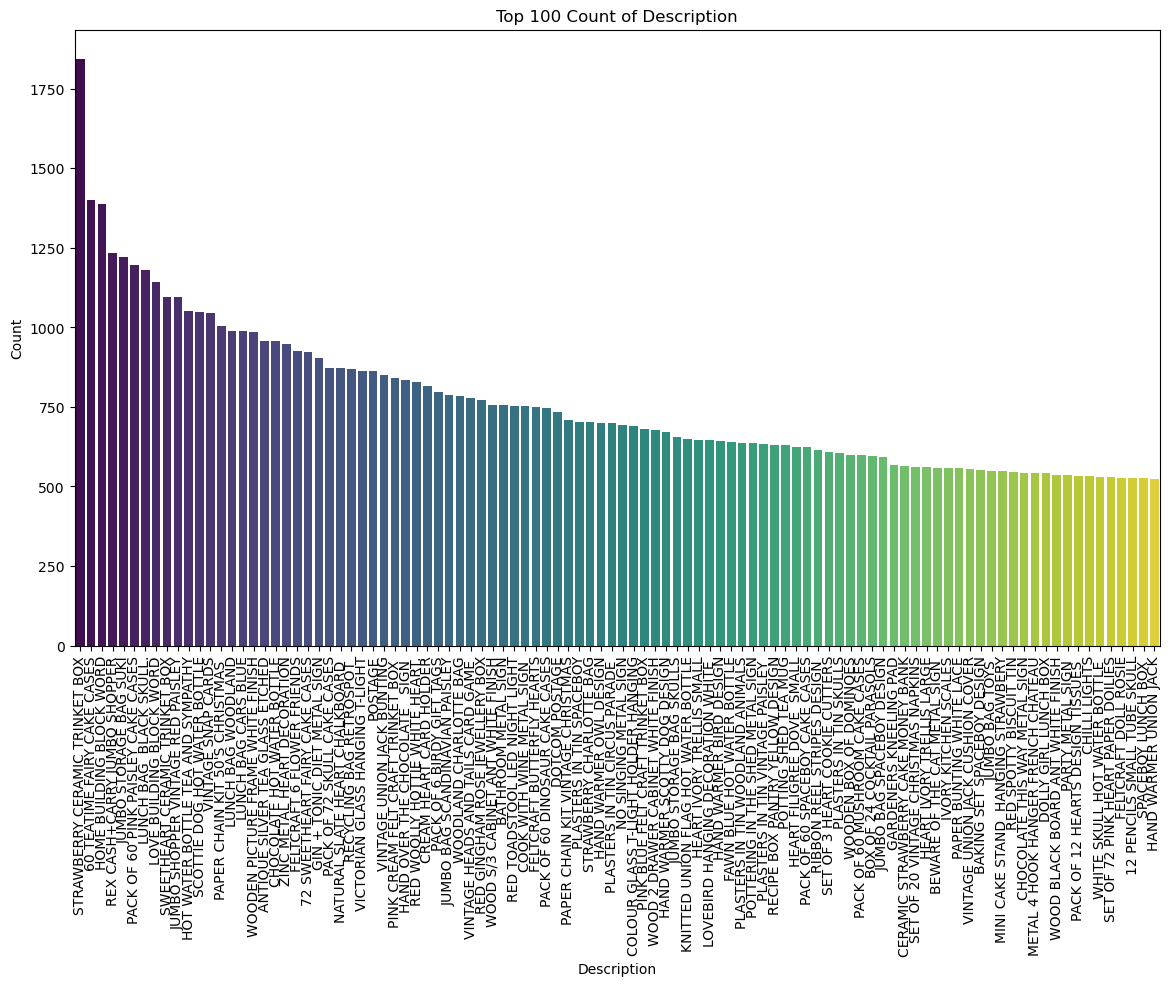

In [162]:
# Calculate count of each Description
stockcode_counts = df['Description'].value_counts().head(100)

# Task 1: Plot count of top 100 Description
plt.figure(figsize=(14, 8))
sns.barplot(x=stockcode_counts.index, y=stockcode_counts.values, palette='viridis')
plt.title('Top 100 Count of Description')
plt.xlabel('Description')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

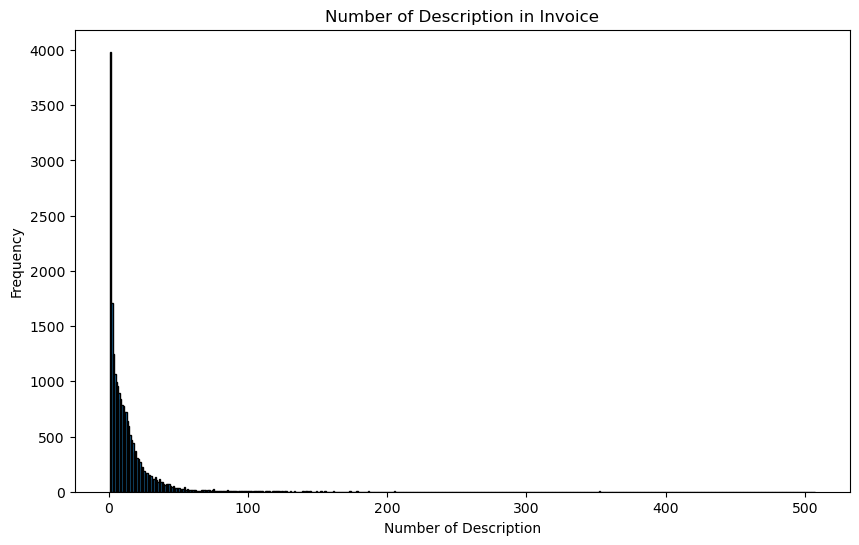

In [163]:
plt.figure(figsize=(10, 6))
stockcode_per_invoice = df.groupby('Invoice')['Description'].nunique()
stockcode_per_invoice.plot(kind='hist', bins=range(1, stockcode_per_invoice.max() + 1), edgecolor='black')
plt.title('Number of Description in Invoice')
plt.xlabel('Number of Description')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# it seems data contains outliner

In [171]:
stockcode_per_invoice.sort_values(ascending=False)

Invoice
537434     507
538071     475
537237     459
537823     454
537638     444
          ... 
C493538      1
514517       1
C493647      1
504710       1
520231       1
Name: Description, Length: 22799, dtype: int64

# 4. Feature engineering

target

In [ ]:
# target

In [ ]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

features

In [ ]:
# PaymentMethod (one hot)

In [ ]:
for payment_method in df['PaymentMethod'].unique():
    df['PaymentMethod_' + payment_method] = df['PaymentMethod'].apply(lambda x: 1 if x == payment_method else 0)
df = df.drop('PaymentMethod', axis=1)

In [ ]:
# Gender

In [ ]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [ ]:
# Partner

In [ ]:
df['Partner'] = df['Partner'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Dependents

In [ ]:
df['Dependents'] = df['Dependents'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# PhoneService

In [ ]:
df['PhoneService'] = df['PhoneService'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# MultipleLines

In [ ]:
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# InternetService

In [ ]:
df['InternetService'] = df['InternetService'].apply(lambda x: 2 if x == 'Fiber optic' else 1 if x == 'DSL' else 0)

In [ ]:
# OnlineSecurity

In [ ]:
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# OnlineBackup

In [ ]:
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# DeviceProtection

In [ ]:
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# TechSupport

In [ ]:
df['TechSupport'] = df['TechSupport'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# StreamingTV

In [ ]:
df['StreamingTV'] = df['StreamingTV'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# StreamingMovies

In [ ]:
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Contract

In [ ]:
df['Contract'] = df['Contract'].apply(lambda x: 0 if x == 'Month-to-month' else 1 if x == 'One year' else 2)

In [ ]:
# PaperlessBilling

In [ ]:
df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda x: 1 if x == 'Yes' else 0)

fill na

In [ ]:
df.isna().sum()

In [ ]:
# TotalCharges

In [ ]:
median_tol_charges = df['TotalCharges'].median()

In [ ]:
median_tol_charges

In [ ]:
df['TotalCharges'].fillna(median_tol_charges, inplace=True)

In [ ]:
df.isna().sum()

drop unnecessary columns

In [ ]:
# drop customerID

In [ ]:
df.drop(columns = 'customerID', inplace = True)

correlation

In [ ]:
# check correlation

In [ ]:
corr = df.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [ ]:
corr_churn_table = corr['Churn'].sort_values(ascending=False)

In [ ]:
corr_churn_table

In [ ]:
corr_churn_abs_table = corr['Churn'].abs().sort_values(ascending=False)

In [ ]:
corr_churn_abs_table

# 5. Model

In [ ]:
# Only Class 0
# Only Class 1

# Normalized > SMOTE > RF (Random Search)
# Normalized > SMOTE > LightGBM (Random Search)
# Normalized > SMOTE > XGBoost (Random Search)

# Normalized > ADASYN > RF (Random Search)
# Normalized > ADASYN > LightGBM (Random Search)
# Normalized > ADASYN > XGBoost (Random Search)

# Normalized > RUS > RF (Random Search)
# Normalized > RUS > LightGBM (Random Search)
# Normalized > RUS > XGBoost (Random Search)

Step 1: Train/Test/Validation Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
X_train = train_df.drop(columns=['Churn'])
y_train = train_df['Churn']
X_val = val_df.drop(columns=['Churn'])
y_val = val_df['Churn']
X_test = test_df.drop(columns=['Churn'])
y_test = test_df['Churn']

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)
 
print(X_test.shape)
print(y_test.shape)

Step 2: Normalize Min-Max Scaling

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Step 3.1: predicts only 1

In [ ]:
dummy_all_churn = DummyClassifier(strategy='constant', constant=1)
dummy_all_churn.fit(X_train_scaled, y_train)

Step 3.2: predicts only 0

In [ ]:
dummy_all_not_churn = DummyClassifier(strategy='constant', constant=0)
dummy_all_not_churn.fit(X_train_scaled, y_train)

Step 3.3: Smote + RF

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_smote_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
rf_smote_random_search.fit(X_train_smote, y_train_smote)

In [ ]:
rf_smote_random_search.best_score_

In [ ]:
rf_smote = rf_smote_random_search.best_estimator_

Step 3.4: Smote + LGBM

In [ ]:
lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_smote_random_search = RandomizedSearchCV(lgbm, param_distributions=lgbm_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_smote_random_search.fit(X_train_smote, y_train_smote)

In [ ]:
lgbm_smote_random_search.best_score_

In [ ]:
lgbm_smote = lgbm_smote_random_search.best_estimator_

Step 3.5: Smote + XGB

In [ ]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb = XGBClassifier(random_state=42)
xgb_smote_random_search = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_smote_random_search.fit(X_train_smote, y_train_smote)

In [ ]:
xgb_smote_random_search.best_score_

In [ ]:
xgb_smote = xgb_smote_random_search.best_estimator_

Step 3.6: ADASYN + RF

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_adasyn_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
rf_adasyn_random_search.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
rf_adasyn_random_search.best_score_

In [ ]:
rf_adasyn = rf_adasyn_random_search.best_estimator_

Step 3.7: ADASYN + LGBM

In [ ]:
lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_adasyn_random_search = RandomizedSearchCV(lgbm, param_distributions=lgbm_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_adasyn_random_search.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
lgbm_adasyn_random_search.best_score_

In [ ]:
lgbm_adasyn = lgbm_adasyn_random_search.best_estimator_

Step 3.8: ADASYN + XGB

In [ ]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb = XGBClassifier(random_state=42)
xgb_adasyn_random_search = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_adasyn_random_search.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
xgb_adasyn_random_search.best_score_

In [ ]:
xgb_adasyn = xgb_adasyn_random_search.best_estimator_

Step 3.9: RUS + RF

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_rus_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
rf_rus_random_search.fit(X_train_rus, y_train_rus)

In [ ]:
rf_rus_random_search.best_score_

In [ ]:
rf_rus = rf_rus_random_search.best_estimator_

Step 3.10: RUS + LGBM

In [ ]:
lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
lgbm_rus = LGBMClassifier(random_state=42)
lgbm_rus_random_search = RandomizedSearchCV(lgbm_rus, param_distributions=lgbm_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_rus_random_search.fit(X_train_rus, y_train_rus)

In [ ]:
lgbm_rus_random_search.best_score_

In [ ]:
lgbm_rus = lgbm_rus_random_search.best_estimator_

Step 3.11: RUS + XGB

In [ ]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb_rus = XGBClassifier(random_state=42)
xgb_rus_random_search = RandomizedSearchCV(xgb_rus, param_distributions=xgb_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_rus_random_search.fit(X_train_rus, y_train_rus)

In [ ]:
xgb_rus_random_search.best_score_

In [ ]:
xgb_rus = xgb_rus_random_search.best_estimator_

# 6. Result (precision/recall/AUC-ROC)

In [ ]:
models = {
    'Dummy Model (All Churn)': dummy_all_churn,
    'Dummy Model (All Not Churn)': dummy_all_not_churn,
    'Random Forest (SMOTE)': rf_smote,
    'LightGBM (SMOTE)': lgbm_smote,
    'XGBoost (SMOTE)': xgb_smote,

    'Random Forest (ADASYN)': rf_adasyn,
    'LightGBM (ADASYN)': lgbm_adasyn,
    'XGBoost (ADASYN)': xgb_adasyn,

    'Random Forest (RUS)': rf_rus,
    'LightGBM (RUS)': lgbm_rus,
    'XGBoost (RUS)': xgb_rus
}

In [ ]:
summary_metrics = pd.DataFrame(columns=['Model', 'Observation', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'AUCROC'])

In [ ]:
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    model_summary = pd.DataFrame({
        'Model': [model_name],
        'Observation': [len(y_test)],
        'TP': [tp],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'Precision': [precision],
        'Recall': [recall],
        'AUCROC': [auc_roc]
    })

    summary_metrics = pd.concat([summary_metrics, model_summary], ignore_index=True)

In [ ]:
summary_metrics

# 7. Threshold tunning

In [ ]:
# Assume
# Cost of promotion = 100
# Cost of losing customer = 500 (5 times)

In [ ]:
# ref from https://github.com/stephenblount/Churn_Classification/blob/main/Final_Analysis/Churn_Analysis_Final.ipynb

In [ ]:
cost_promotion = 100
cost_loss = 500
savings_per_customer = 500

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 101 thresholds from 0 to 1

In [ ]:
best_thresholds = {}
gains_val = {}
gains_test = {}

In [ ]:
for model_name, model in models.items():

    model_gains_val = []
    model_gains_test = []

    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    if model_name == 'Dummy Model (All Churn)':
        y_pred_proba = y_pred_proba + 0.1
    elif model_name == 'Dummy Model (All Not Churn)':
        y_pred_proba = y_pred_proba - 0.1

    model_gains = []
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y_val, y_pred)
        costs = (cm[0, 1] * cost_promotion) + (cm[1, 0] * cost_loss)
        savings = cm[1, 1] * savings_per_customer
        gain = savings - costs
        model_gains.append(gain)

    best_threshold_idx = np.argmax(model_gains)
    best_threshold = thresholds[best_threshold_idx]
    
    best_thresholds[model_name] = (best_threshold, max(model_gains))
    gains_val[model_name] = model_gains
    
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    if model_name == 'Dummy Model (All Churn)':
        y_test_pred_proba = y_test_pred_proba + 0.1
    elif model_name == 'Dummy Model (All Not Churn)':
        y_test_pred_proba = y_test_pred_proba - 0.1 

    y_test_pred = (y_test_pred_proba > best_threshold).astype(int)
    cm_test = confusion_matrix(y_test, y_test_pred)  
    costs_test = (cm_test[0, 1] * cost_promotion) + (cm_test[1, 0] * cost_loss)
    savings_test = cm_test[1, 1] * savings_per_customer   
    gain_test = savings_test - costs_test

    gains_test[model_name] = gain_test

In [ ]:
best_thresholds

In [ ]:
gains_test

In [ ]:
summary_thresholds = pd.DataFrame(columns=['Model', 'Best Threshold', 'Validation Gain', 'Test Gain'])

In [ ]:
for model_name, model_gains_val in gains_val.items():
    best_threshold, _ = best_thresholds[model_name]

    model_summary_thresholds = pd.DataFrame({
        'Model': [model_name],
        'Best Threshold': [best_threshold],
        'Validation Gain': [max(model_gains_val)],
        'Test Gain': [gains_test[model_name]]
    })

    summary_thresholds = pd.concat([summary_thresholds, model_summary_thresholds], ignore_index=True)

In [ ]:
summary_thresholds

# 8. Result (threshold/cost)

In [ ]:
summary_df = pd.merge(summary_metrics, summary_thresholds, on="Model", how="left")

In [ ]:
summary_df

In [ ]:
y_test.shape

In [ ]:
# rf_rus is the best model in term of gains

# 9. SHAP

In [ ]:
column_names = X_train.columns.tolist()

In [ ]:
explainer = shap.Explainer(lgbm_rus)
shap_values = explainer.shap_values(X_train_rus)

In [ ]:
explanation = shap.Explanation(values=shap_values[0], data=X_train_rus, feature_names=column_names)

In [ ]:
shap.plots.beeswarm(explanation)
plt.show()

In [ ]:
# top 5 impact features are 1. contract 2. tenue 3. monthlycharges 4. internetservince 5. Payment method (electronic check)